# Quantile regression
Quantile regression is very different from OLS regressor.

- [▶️Quantile Regression ](https://www.youtube.com/watch?v=ZW-zmA9_Pz0)
- 🫥quantile =0.2  预测值大于目标值的概率是0.2 . 即如果100个样本，大概20个样本的预测值大于目标值
- [▶️▶️Quantile Regression](https://www.youtube.com/watch?v=OQGIdfEHNnQ&t=17s)

## basic comprehension

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

📌 Distribution y with noise!

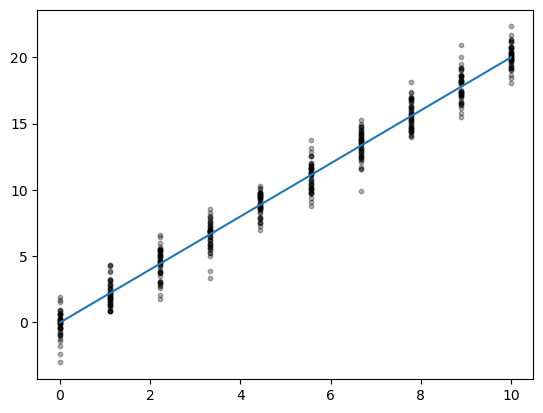

In [5]:
fig,ax = plt.subplots()
x = np.linspace(0,10,10)

ax.plot(x,2*x)
for i in x:
    noise = np.random.normal(scale=1, size=50)
    ax.scatter([i]*len(noise), 2*i + noise, alpha=0.3, color='black', s=10)

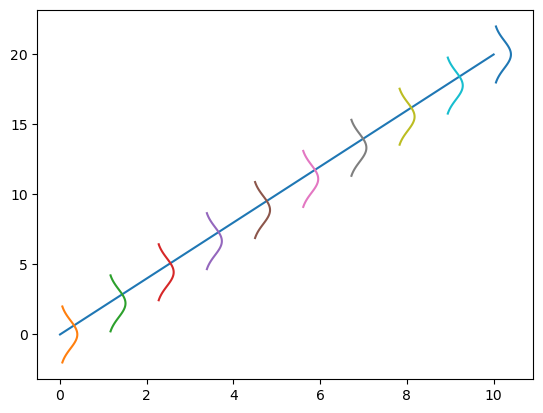

In [6]:
from scipy.stats import norm
fig,ax = plt.subplots()
x = np.linspace(0,10,10)

ax.plot(x,2*x)
for i in x:
    sigma = 1
    mu = 2*i
    y_noise = np.linspace(mu -2*sigma, mu + 2*sigma, 100)
    y_noise_p = norm.pdf(y_noise, mu, sigma)
    ax.plot(i+y_noise_p, y_noise)

In [79]:
X.shape

(100, 1)

In [80]:
y_true_mean.shape

(100, 1)

We will create two subsequent problems by changing the distribution of the target y while keeping the same expected value:

- in the first case, a heteroscedastic Normal noise is added; x↑， noise↑。(正态异方差噪声)
- in the second case, an asymmetric Pareto noise is added.
[Pareto ](https://en.wikipedia.org/wiki/Pareto_distribution)

---

帕累托分布（Pareto Distribution）是一种**长尾分布**，常用于描述**财富分配、城市人口、公司规模、灾难损失**等现实世界中不均匀的现象。  
**1. 定义**
帕累托分布的概率密度函数（PDF）为：
$$
f(x) = \frac{\alpha x_m^\alpha}{x^{\alpha+1}}, \quad x \geq x_m
$$
其中：
- $ \alpha > 0 $ 是**形状参数**（shape parameter），决定分布的陡峭程度
- $ x_m > 0$是**最小值**（scale parameter），表示数据的最小可能值  

如果 $ \alpha $ 较小，意味着极端值（大值）更可能出现；如果 $\alpha $ 较大，数据更集中在较小范围。



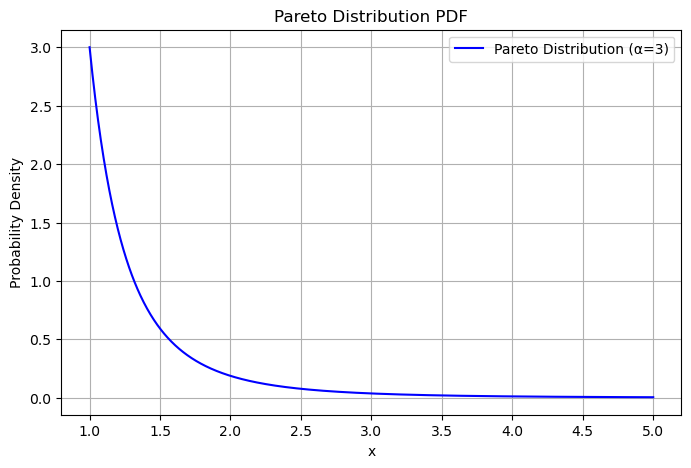

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pareto

# 设定帕累托分布的参数
alpha = 3  # 形状参数 (shape parameter)
x_m = 1  # 最小值 (scale parameter)

# 生成 x 值（从 x_m 开始）
x = np.linspace(x_m, 5, 1000)
y = pareto.pdf(x, alpha, scale=x_m)

# 绘制帕累托分布的概率密度函数（PDF）
plt.figure(figsize=(8, 5))
plt.plot(x, y, label=f"Pareto Distribution (α={alpha})", color='b')
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.title("Pareto Distribution PDF")
plt.legend()
plt.grid()

# 显示图像
plt.show()


---

## generate data

In [14]:
rng = np.random
X = np.linspace(0,10,100)
X = X[:, np.newaxis]
y_true_mean = 10+0.5*X

In [15]:
y_normal = y_true_mean + rng.normal(
    loc=0,
    scale=0.5+0.5*X,
    size = y_true_mean.shape
)
a=5
y_pareto = y_true_mean +  10 * (rng.pareto(a,size=y_true_mean.shape) - 1 / (a - 1))

- 正态异方差noise: 为每个x对应个正态分布，X越大方差越大，但是均值为0.  即这n个噪声是从n个分布产生的。
- 帕累托噪声noise：大部分噪音较小，尾巴的噪声噪声大。

Text(0.5, 0, 'noise')

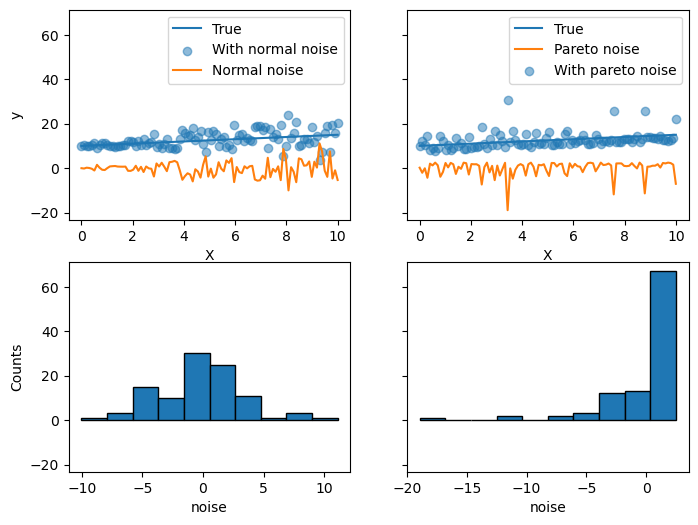

In [16]:
fig, axes = plt.subplots(2,2, figsize=(8,6), sharey= True)

axes[0,0].plot(X,y_true_mean, label='True')
axes[0,0].scatter(X,y_normal, 
                label='With normal noise', alpha=0.5)
axes[0,0].plot(X,y_true_mean - y_normal, label='Normal noise')

axes[0,0].legend()
axes[0,0].set_xlabel('X')
axes[0,0].set_ylabel('y')

axes[1,0].hist(y_true_mean-y_normal,edgecolor='black')
axes[1,0].set_ylabel('Counts')
axes[1,0].set_xlabel('noise')


axes[0,1].plot(X,y_true_mean, label='True')
axes[0,1].plot(X,y_true_mean - y_pareto, label='Pareto noise')
axes[0,1].scatter(X,y_pareto, label='With pareto noise', alpha=0.5)
axes[0,1].legend()
axes[0,1].set_xlabel('X')

axes[1,1].hist(y_true_mean-y_pareto,edgecolor='black')
axes[1,1].set_xlabel('noise')

📌
- 异方差正态噪音中， X越大，噪声越大！
- 帕累托大部分稳定，少数的噪声非常大！

## FIT- Normal noise

In [83]:
y_normal.shape

(100, 1)

In [17]:
from sklearn.linear_model import QuantileRegressor

quantiles = [0.05, 0.5, 0.95] # 表

predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X,y_normal.ravel()).predict(X)
    y_pred = y_pred[:,np.newaxis]
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred > y_normal 
        )
        print(f'SMALL {quantile}, pred>real , counts:{np.sum(y_pred > y_normal)}')
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred < y_normal 
        )
        print(f'BIG {quantile}, pred>real , counts:{np.sum(y_pred >  y_normal)}')
        


SMALL 0.05, pred>real , counts:5
BIG 0.95, pred>real , counts:94


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

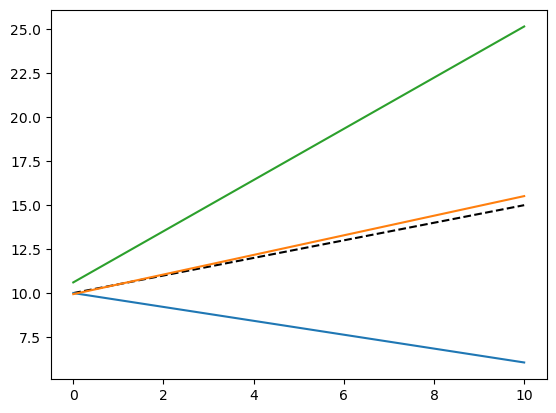

In [18]:
plt.plot(X,y_true_mean, color='black',linestyle='--', label='True')
for quantile,y_pred in predictions.items():
    plt.plot(X,y_pred,label=f"Quantile:{quantile}")
plt.scatter(
    x[out_bounds_predictions],
    y_normal[out_bounds_predictions],
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_normal[~out_bounds_predictions],
    alpha=0.5,
    label="Inside interval",
)
plt.legend()
plt.title(f"QuantileRegression of heteroscedastic Normal distributed noise")

📈
- quantile 0.05 : 大约有5个样本的预测值大于真实值。

## FIT- Petro noise


In [130]:
from sklearn.linear_model import QuantileRegressor

quantiles = [0.05, 0.5, 0.95] # 表

predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X,y_pareto.ravel()).predict(X)
    y_pred = y_pred[:,np.newaxis]
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred > y_pareto 
        )
        print(f'SMALL {quantile}, pred>real , counts:{np.sum(y_pred > y_pareto)}')
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred < y_pareto 
        )
        print(f'BIG {quantile}, pred>real , counts:{np.sum(y_pred >  y_pareto)}')
        


SMALL 0.05, pred>real , counts:5
BIG 0.95, pred>real , counts:94


Text(0.5, 1.0, 'QuantileRegression of Petro distributed noise')

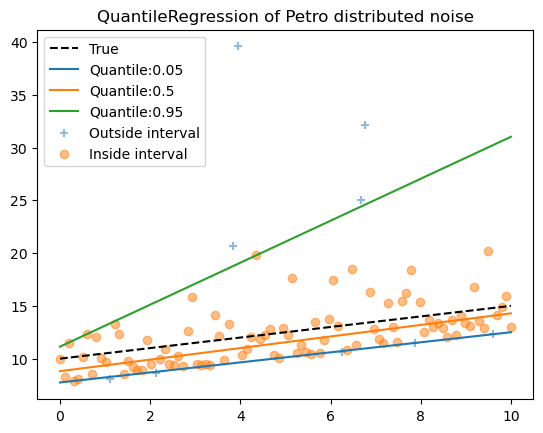

In [132]:
plt.plot(X,y_true_mean, color='black',linestyle='--', label='True')
for quantile,y_pred in predictions.items():
    plt.plot(X,y_pred,label=f"Quantile:{quantile}")
plt.scatter(
    x[out_bounds_predictions],
    y_pareto[out_bounds_predictions],
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_pareto[~out_bounds_predictions],
    alpha=0.5,
    label="Inside interval",
)
plt.legend()
plt.title(f"QuantileRegression of Petro distributed noise")
